In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tdastro.obstable.opsim import OpSim
OPSIM_DB_PATH = "/Users/sidchaini/miniconda3/envs/tdastro/lib/python3.12/data/opsim/baseline_v5.0.0_10yrs.db"  # Path to your downloaded OpSim database
ops_data = OpSim.from_db(OPSIM_DB_PATH)

print(f"Loaded an opsim database with {len(ops_data)} entries.")
print(f"Columns: {ops_data.columns}")

ddf_idx = ops_data["science_program"][ops_data["science_program"]=="DD"].index
ddf_table = ops_data._table.iloc[ddf_idx]

nonddf_idx = ops_data["science_program"][ops_data["science_program"]!="DD"].index
nonddf_table = ops_data._table.iloc[nonddf_idx]

lsstcolorplot = {
    "u": "#785EF0",
    "g": "#7DDEB2",
    "r": "#DC267F",
    "i": "#FE6100",
    "z": "#FFB000",
    "y": "#5F3331",
}

lc = pd.read_csv("lc.csv",sep=" ").set_index("SNID")
meta = pd.read_csv("meta.csv",sep=" ").set_index("SNID")
lc["FLT"] = lc["FLT"].str.lower()

Loaded an opsim database with 2048612 entries.
Columns: Index(['observationId', 'ra', 'dec', 'time', 'flush_by_mjd', 'exptime', 'band',
       'filter', 'rotSkyPos', 'rotSkyPos_desired', 'nexposure', 'airmass',
       'seeingFwhm500', 'seeing', 'seeingFwhmGeom', 'skybrightness', 'night',
       'slewTime', 'visitTime', 'slewDistance', 'fiveSigmaDepth', 'altitude',
       'azimuth', 'paraAngle', 'pseudoParaAngle', 'cloud', 'moonAlt', 'sunAlt',
       'scheduler_note', 'target_name', 'target_id', 'observationStartLST',
       'rotTelPos', 'rotTelPos_backup', 'moonAz', 'sunAz', 'sunRA', 'sunDec',
       'moonRA', 'moonDec', 'moonDistance', 'solarElong', 'moonPhase',
       'cummTelAz', 'observation_reason', 'science_program',
       'cloud_extinction', 'zp'],
      dtype='object')


## Choose

In [2]:
table = nonddf_table

In [39]:
meta_idx = meta.sample(n=1).index[0]
print(f"Chose {meta_idx} ({meta.loc[meta_idx, 'SIM_TYPE_NAME']})")

cur_lc = lc.loc[meta_idx]

Chose 25466351 (CART)


In [40]:
choose_idx = table.sample(n=1).index[0]
choose_ra = table.loc[choose_idx]["ra"]
choose_dec = table.loc[choose_idx]["dec"]
choose_time = table.loc[choose_idx]["time"]

In [41]:
cur_lc["LSSTDATE"] = (cur_lc["MJD"] + (choose_time - cur_lc["MJD"].min()))

/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_86193/984652313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_lc["LSSTDATE"] = (cur_lc["MJD"] + (choose_time - cur_lc["MJD"].min()))


In [42]:
dat=pd.DataFrame(
    ops_data.get_observations(
        query_ra=choose_ra,
        query_dec=choose_dec,
        cols=["time", "band"],
        t_min = cur_lc["LSSTDATE"].min(),
        t_max = cur_lc["LSSTDATE"].max()
    )
)

In [43]:
cur_lc_renamed = cur_lc.rename(columns={'LSSTDATE': 'time', 'FLT': 'band'})
dat_sorted = dat.sort_values('time')
cur_lc_sorted = cur_lc_renamed.sort_values('time')
merged_df = pd.merge_asof(
    dat_sorted,
    cur_lc_sorted,
    on='time',
    by='band',
    direction='nearest',
    tolerance=cur_lc["MJD"].diff().max(), # 1 or 2
)

cur_lc_crop = merged_df.groupby([ "MJD", "band"]).sample(n=1)

In [44]:
cur_lc_crop["band"].value_counts()

band
r    12
z    12
i     9
y     5
g     4
u     4
Name: count, dtype: int64

In [45]:
cur_lc_crop = cur_lc_crop[["MJD", "band"]]
cur_lc_crop.columns = ["MJD", "FLT"]

In [46]:
# cur_lc = cur_lc.reset_index(drop=False).set_index(list(cur_lc_crop.columns))

In [47]:
cur_lc_crop = pd.merge(cur_lc, cur_lc_crop, on=['MJD', 'FLT'])

In [48]:
cur_lc.loc[:,"MJD_DIFF"] = cur_lc["MJD"] - cur_lc["MJD"].min()
cur_lc_crop.loc[:,"MJD_DIFF"] = cur_lc_crop["MJD"] - cur_lc["MJD"].min()

/var/folders/2d/ht34x6mn7hx9d1sv4g_j8nfr0000gn/T/ipykernel_86193/362524121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_lc.loc[:,"MJD_DIFF"] = cur_lc["MJD"] - cur_lc["MJD"].min()


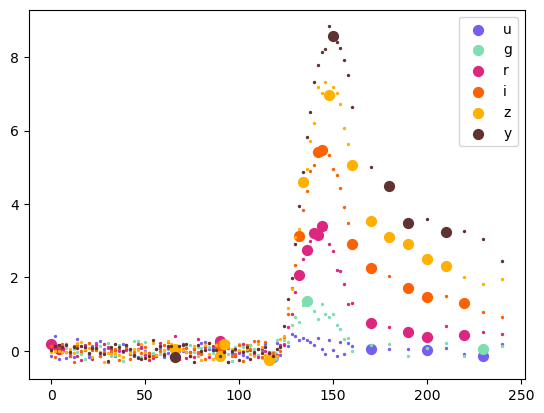

In [49]:
for ch in "ugrizy":
    cur_lc_band = cur_lc[cur_lc["FLT"]==ch]
    plt.scatter(
        cur_lc_band["MJD_DIFF"],cur_lc_band["FLUXCAL"], alpha=1,
        color=lsstcolorplot[ch], s=2)
    
    cur_lc_crop_band = cur_lc_crop[cur_lc_crop["FLT"]==ch]
    plt.scatter(
        cur_lc_crop_band["MJD_DIFF"],cur_lc_crop_band["FLUXCAL"],
        label=ch,
        s=50,
        color=lsstcolorplot[ch])

plt.legend()
plt.show()

In [22]:
# dat["time"] = dat["time"].round()
# dat
    
# cur_lc["LSSTDATE"] = cur_lc["LSSTDATE"].round()
# cur_lc


# cur_lc_crop = pd.merge(
#     cur_lc,
#     dat,
#     left_on="LSSTDATE",
#     right_on="time"
# )

# cur_lc_crop = cur_lc_crop[cur_lc_crop["band"] == cur_lc_crop["FLT"]]

In [271]:
# pd.merge(
#     cur_lc,
#     dat,
#     left_on="LSSTDATE",
#     right_on="time"
# )

In [258]:
# cur_lc_crop = pd.merge_asof(
#     dat,
#     cur_lc,
#     left_on='time',
#     right_on='LSSTDATE',
#     direction='nearest',
#     tolerance=1
# )

# # cur_lc_crop = cur_lc_crop[cur_lc_crop["band"] == cur_lc_crop["FLT"]]